# Last Cycle
Now that the cycle stabilized we can cycle one more time to track relevant quantities:
- Mutual Information
- Work
- Heat
- Internal Energy (?)

In [1]:
include("./modules/OpticalCavity.jl")
include("./modules/Thermodynamics.jl")
include("./modules/Phaseonium.jl")
include("./modules/BosonicOperators.jl")
include("./modules/Measurements.jl")

using LinearAlgebra
using SparseArrays
using ProgressBars
using Plots; gr()
using LaTeXStrings
using TOML
# Saving the output matrix
using Serialization

using .OpticalCavity
using .Thermodynamics
using .Phaseonium
using .BosonicOperators
using .Measurements

include("./src/RoutineFunctions.jl")

plot_in_time (generic function with 1 method)

In [2]:
dir = "cascade_15D_I3";
config = ""
try
    config = TOML.parsefile(dir * "/config.toml")
catch e
    println("Error reading configuration: $e")
else
    println(config["description"])
end

const NDIMS = config["dims"]
const Ω = config["omega"]
const Δt = config["dt"]

const T_initial = config["T_initial"]

# Create a Cavity
const mass = config["cavity"]["mass"]
const surface = config["cavity"]["surface"]
const α0 = config["cavity"]["alpha"]
const l_min = config["cavity"]["min_length"]
const l_max = config["cavity"]["max_length"]
const expanding_force = config["cavity"]["external_force"]
cavity1 = Cavity(mass, surface, l_min, l_max, α0, expanding_force)
cavity2 = Cavity(mass, surface, l_min, l_max, α0, expanding_force)
ω_max = α0 / l_min
ω_min = α0 / l_max

# The system starts contracted, where the frequency is maximum
ρt = thermalstate(NDIMS, ω_max, T_initial)
println(
    "Initial Temperature of the Cavity:
    $(Measurements.temperature(ρt, ω_max))")

# Jump Operators
a = BosonicOperators.destroy(NDIMS)
ad = BosonicOperators.create(NDIMS)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating at minimum length
const ϕ_h = π / config["phaseonium"]["phi_hot"]
const T_hot = config["phaseonium"]["T_hot"]
α_h = Phaseonium.alpha_from_temperature(T_hot, ϕ_h, ω_max) 

const ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)
println(
    "Apparent Temperature carried by Hot Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω_max, ga_h, gb_h))")

bosonic_h = bosonic_operators(Ω, Δt, NDIMS)

# Cooling at maximum length
const ϕ_c = π / config["phaseonium"]["phi_cold"]
const T_cold = config["phaseonium"]["T_cold"]
α_c = Phaseonium.alpha_from_temperature(T_cold, ϕ_c, ω_min) 

const ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
println(
    "Apparent Temperature carried by Cold Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω_min, ga_c, gb_c))")

bosonic_c = bosonic_operators(Ω, Δt, NDIMS);

total_cycles = config["loading"]["past_cycles"]
system_evolution = []
;

Simulation 2 - 15D - Long thermalization - No entanglement

Initial Temperature of the Cavity:
    2.0
Apparent Temperature carried by Hot Phaseonium atoms: 
    3.0000000000000004
Apparent Temperature carried by Cold Phaseonium atoms: 
    1.5000000000000002


### Load or Create State

In [3]:
state = load_or_create(dir, config)
;
# Check number of photons and cutoff
ρ₁ = partial_trace(real(state.ρ), (NDIMS, NDIMS), 1)
println("Average Photons: $(tr(ρ₁ * ad*a))")
println("Last Element $(ρ₁[end])")

Starting with a new cascade system (contracted)
Initial Temperature of the Cavity:
            2.0
Average Photons: 0.26243430854836325
Last Element 2.229239524311487e-10


In [4]:
# Reinitialize memory
state.ρ₁_evolution = [] 
state.ρ₂_evolution = []
state.c₁_evolution = []
state.c₂_evolution = [];

### Cycle

Cycle 1
Isochoric Stroke


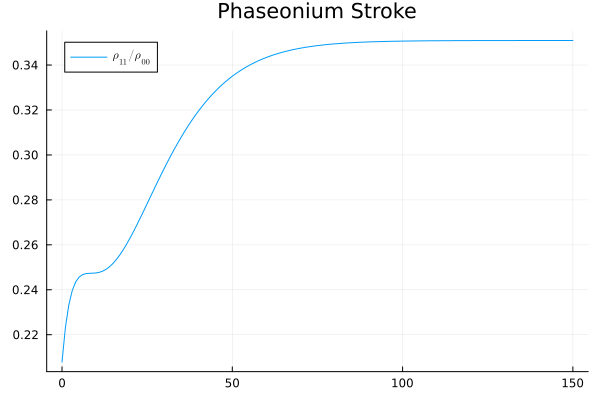

Adiabatic Stroke


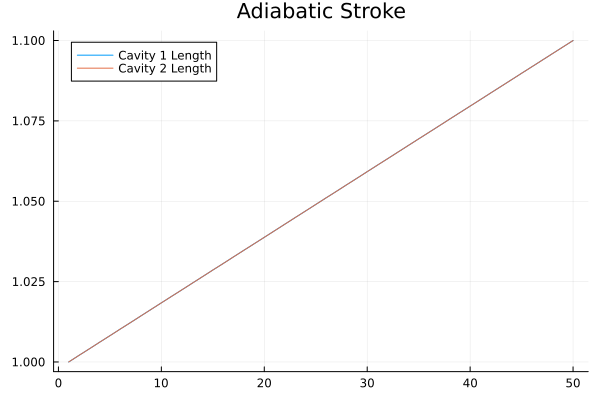

Isochoric Stroke


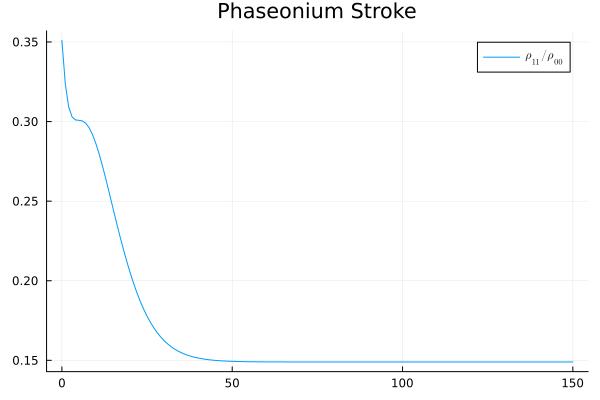

Adiabatic Stroke


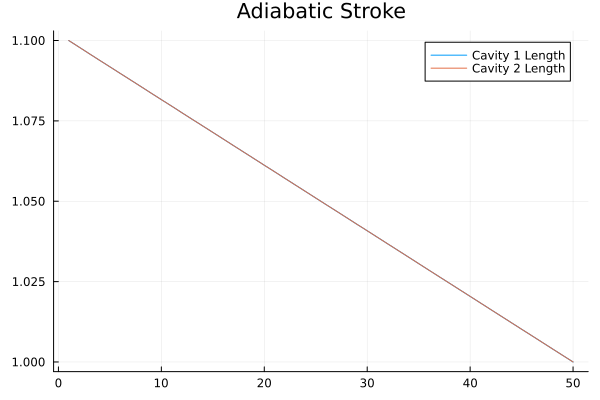

Cycle 2
Isochoric Stroke


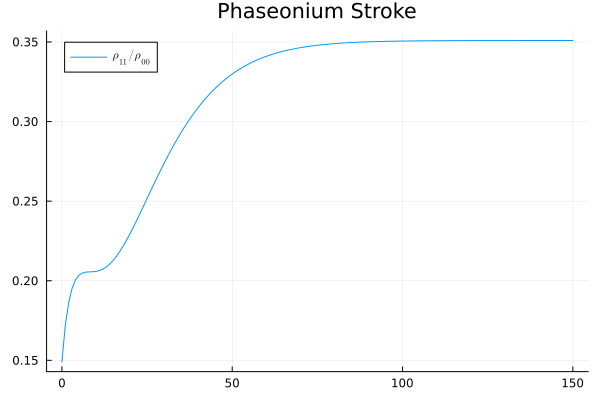

Adiabatic Stroke


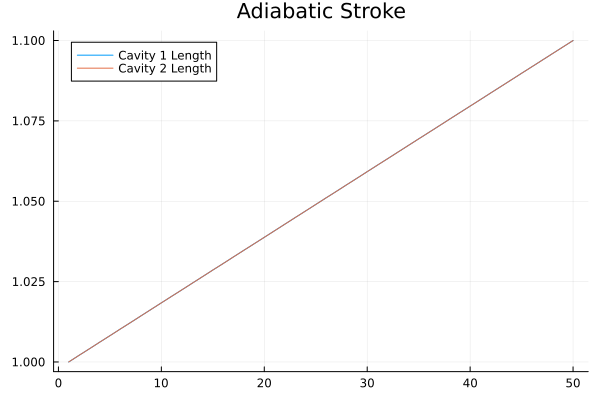

Isochoric Stroke


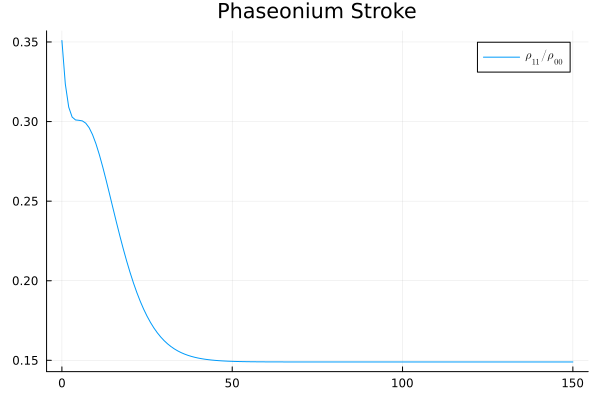

Adiabatic Stroke


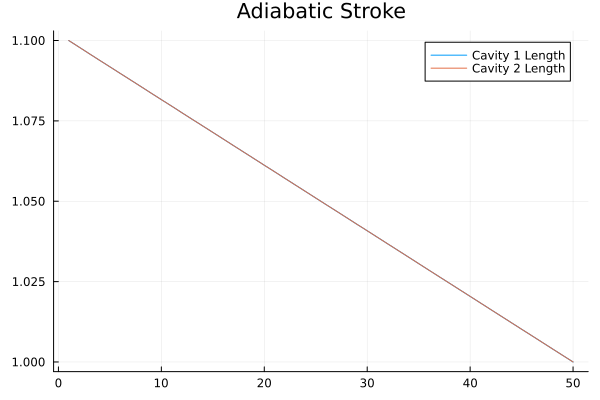

In [5]:
isochore_time = config["stroke_time"]["isochore"]
isochore_samplings = config["samplings"]["isochore"]
adiabatic_time = config["stroke_time"]["adiabatic"]
adiabatic_samplings = config["samplings"]["adiabatic"]

total_cycle_time = isochore_samplings * 2 + 2 * adiabatic_samplings + 2

for t in 1:2
    println("Cycle $t")
    state, system_evolution = cycle(state, system_evolution, isochore_time, isochore_samplings, adiabatic_time, adiabatic_samplings);
    total_cycles += 1
end


### Check stability of the Cycle

(804,)


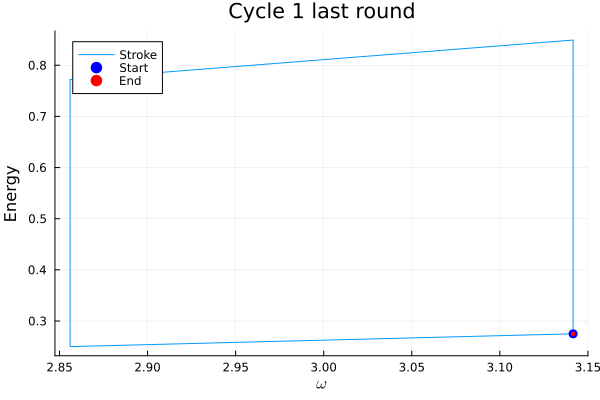

In [6]:
println(size(system_evolution))
state_evolution = state.ρ₁_evolution[end-total_cycle_time+1:end] # last cycle
cavity_evolution = state.c₁_evolution[end-total_cycle_time+1:end] # last cycle
measure_and_plot("Frequency", "Energy", state_evolution, cavity_evolution, "Cycle 1 last round"; α=π)

## Measure the Evolving Cascade State

In [7]:
include("./src/RoutineFunctions.jl")

plot_in_time (generic function with 1 method)

## Entropy

In [8]:
SA = [Measurements.entropy_vn(ρ) for ρ in state.ρ₁_evolution]
SB = [Measurements.entropy_vn(ρ) for ρ in state.ρ₂_evolution]

SAB = [Measurements.entropy_vn(ρ) for ρ in system_evolution];

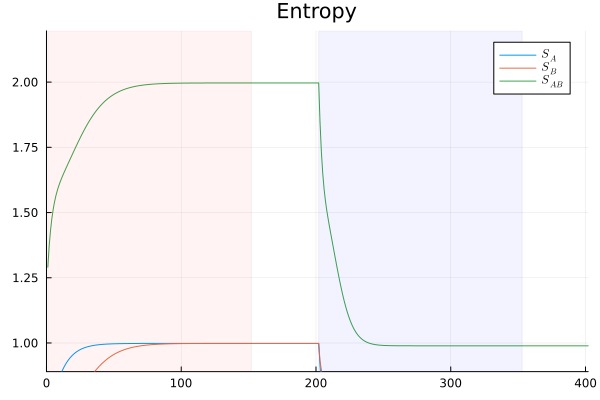

In [9]:
g = plot([SA, SB, SAB], label=[L"S_A" L"S_B" L"S_{AB}"], title="Entropy")
plot_strokes_overlays(g, SAB, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

In [10]:
savefig(g, dir * "/entropy.png")
savefig(g, dir * "/entropy.pdf")

"/home/pmxfa13/phaseonium/thermophaseonium/julia/cascade_15D_I3/entropy.pdf"

### Mutual Information
Measure the correlation between the two cavities during the cycle

In [11]:
I = SA .+ SB .- SAB;

Mutual Information goes down to: -7.224083e-5


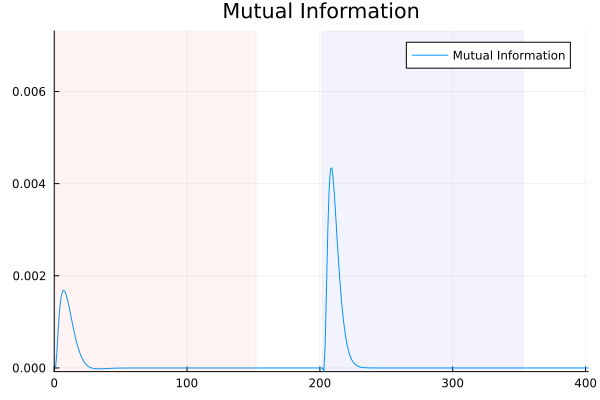

In [12]:
println("Mutual Information goes down to: $(minimum(I))")
g = plot(I, label="Mutual Information", title="Mutual Information")
plot_strokes_overlays(g, I, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

In [13]:
savefig(g, dir * "/mutual_info.png")
savefig(g, dir * "/mutual_info.pdf")

"/home/pmxfa13/phaseonium/thermophaseonium/julia/cascade_15D_I3/mutual_info.pdf"

### Heat
By Alicki definition
$$
Q = \text{Tr}\{\Delta\rho H(\omega)\} = \text{Tr}\{\rho_{n+1}H(\omega)\} - \text{Tr}\{\rho_{n}H(\omega)\} 
$$
Here heating and cooling happens with two different cavity lengths (two different $\omega$)

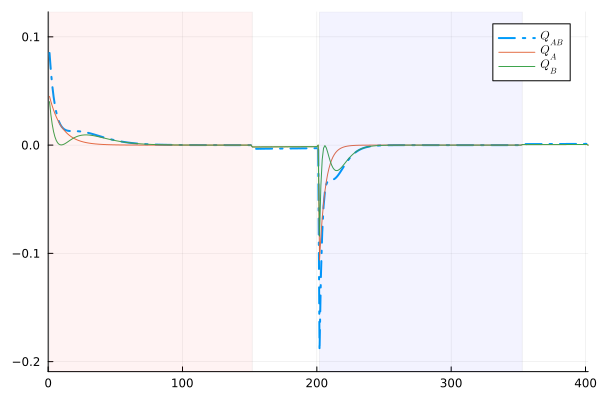

In [14]:
ω₁_evolution = [α0 / l1 for l1 in state.c₁_evolution]
ω₂_evolution = [α0 / l2 for l2 in state.c₂_evolution]
# Expectation value of the Hamiltonians
energies_s₁ = [Measurements.avg_E(ρ, ω) for (ρ, ω) in zip(state.ρ₁_evolution, ω₁_evolution)]
energies_s₂ = [Measurements.avg_E(ρ, ω) for (ρ, ω) in zip(state.ρ₂_evolution, ω₂_evolution)]
# Heat absorbed and given
q₁ = [energies_s₁[i+1] - energies_s₁[i] for i in 1:length(energies_s₁)-1]
q₂ = [energies_s₂[i+1] - energies_s₂[i] for i in 1:length(energies_s₂)-1]

g_heat = plot(q₁+q₂, label=L"Q_{AB}", linewidth=2, linestyle=:dashdot)
plot!(q₁, label=L"Q_A")
plot!(q₂, label=L"Q_B")
plot_strokes_overlays(g_heat, q₁+q₂, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

### Work
by Alicki definition
$$
W = \text{Tr}\{\rho\Delta H\} = \text{Tr}\{\rho H(\omega_{n+1})\} - \text{Tr}\{\rho H(\omega_n)\} 
$$
Here $\rho$ should always be the same (when written in the eigenbasis of its respective Hamiltonian.

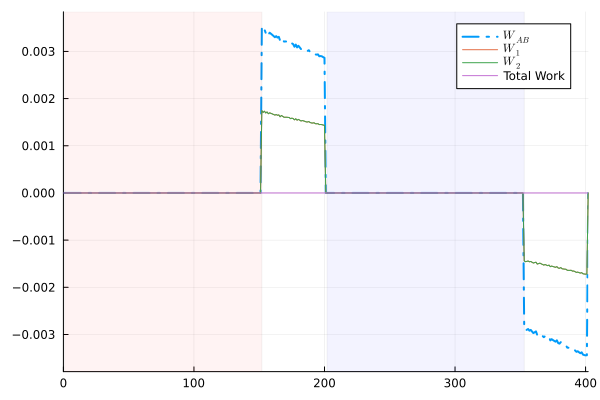

In [15]:
# Expectation value of the Hamiltonians
ρ = state.ρ₁_evolution[isochore_samplings + 1]
energies_s₁ = [Measurements.avg_E(ρ, ω) for ω in ω₁_evolution]
energies_s₂ = [Measurements.avg_E(ρ, ω) for ω in ω₂_evolution]
# Work done on the system and from it
w₁ = [energies_s₁[i+1] - energies_s₁[i] for i in 1:length(energies_s₁)-1]
w₂ = [energies_s₂[i+1] - energies_s₂[i] for i in 1:length(energies_s₂)-1]
net_w = sum(w₁+w₁)

g_work = plot(-w₁-w₁, label=L"W_{AB}", linewidth=2, linestyle=:dashdot)
plot!(-w₁, label=L"W_1")
plot!(-w₂, label=L"W_2")
plot!([0, total_cycle_time], [-net_w, -net_w], label="Total Work")
plot_strokes_overlays(g_work, -w₁-w₁, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

We can as well compute the work ``classically'' knowing the movement of the cavity wall and the force acting on it
$$
W = F \Delta l = p S \Delta l
$$

Net work: 0.21184425239419027


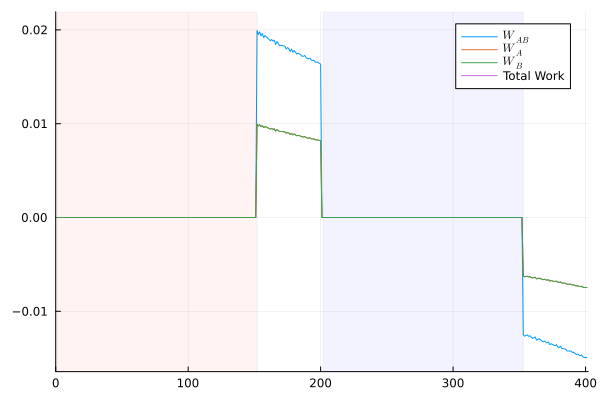

In [16]:
identity_matrix = spdiagm(ones(NDIMS))
# Pressure Operator
function pressure_operator(ω, t, adiabatic_samplings, a, ad)
    t = t*adiabatic_samplings
    2 * a * ad  - a * a * exp(-2*im*ω*t) - ad * ad * exp(2*im*ω*t)
end
π₁_evolution = [pressure_operator(ω₁_evolution[i], i, adiabatic_samplings, a, ad)
    for i in 1:total_cycle_time]
π₂_evolution = [pressure_operator(ω₂_evolution[i], i, adiabatic_samplings, a, ad)
    for i in 1:total_cycle_time]
s1 = cavity1.surface
s2 = cavity2.surface
p1 = [Measurements.pressure(ρ, π₁, identity_matrix, α0, l, s1)
    for (ρ, π₁, l) in zip(state.ρ₁_evolution, π₁_evolution, state.c₁_evolution)]
p2 = [Measurements.pressure(ρ, π₂, identity_matrix, α0, l, s2)
    for (ρ, π₂, l) in zip(state.ρ₂_evolution, π₂_evolution, state.c₂_evolution)]

# Optomechanical Work
w₁ = [p*s1*(state.c₁_evolution[i+1]-state.c₁_evolution[i]) for (p, i) in zip(p1, 1:total_cycle_time-1)]
w₂ = [p*s2*(state.c₂_evolution[i+1]-state.c₂_evolution[i]) for (p, i) in zip(p2, 1:total_cycle_time-1)]
net_w = sum(w₁+w₁)
println("Net work: $net_w")

g_press = plot(w₁+w₁, label=L"W_{AB}")
plot!(w₁, label=L"W_{A}")
plot!(w₂, label=L"W_{B}")
plot!([0, total_cycle_time], [sum(w₁), sum(w₁)], label="Total Work")
plot_strokes_overlays(g_press, w₁+w₁, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

### Efficiency
We can now compute efficiency as
$$
\eta = \frac{|W_\text{net}|}{Q_\text{in}}
$$

As a reference we can use Carnot Efficiency
$$
\eta_C = 1 - \frac{T_c}{T_h}
$$
or better the Curzon-Ahlborn Efficiency
$$
\eta_{CA} = 1 - \left(\frac{T_c}{T_h}\right)^{1/2}
$$

In [17]:
# At what temperatures the machine operates?
temperatures_1 = [Measurements.temperature(ρ, ω) for (ρ, ω) in zip(state.ρ₁_evolution, ω₁_evolution)]
temperatures_2 = [Measurements.temperature(ρ, ω) for (ρ, ω) in zip(state.ρ₂_evolution, ω₂_evolution)]

T₁_hot = maximum(temperatures_1)
T₁_cold = minimum(temperatures_1)
println("Cavity A operates between the temperatures:\n $T₁_hot - $T₁_cold")
T₂_hot = maximum(temperatures_2)
T₂_cold = minimum(temperatures_2)
println("Cavity B operates between the temperatures:\n $T₂_hot - $T₂_cold")

T_cold_pred = - ω₁_evolution[end-adiabatic_samplings+2] / log(ga_c/gb_c)
T_hot_pred = - ω₁_evolution[1] / log(ga_h/gb_h)
# T_cold_pred = - ω₁_evolution[end] / log(ga_c/(1-ga_c/2))

Cavity A operates between the temperatures:
 2.9999999198189755 - 1.5000000000000082
Cavity B operates between the temperatures:
 2.9999788180819054 - 1.5000000000024742


3.0000000000000004

In [18]:
η₁C = round(1 - T₁_cold / T₁_hot, digits=3)
η₁CA = round(1 - sqrt(T₁_cold / T₁_hot), digits=3)
η₂C = round(1 - T₂_cold / T₂_hot, digits=3)
η₂CA = round(1 - sqrt(T₂_cold / T₂_hot), digits=3)
# Classic Efficiency (with classical temperatures)
T₁_hot_cl = classic_temp(T₁_hot, α_h, ϕ_h)
T₁_cold_cl = classic_temp(T₁_cold, α_c, ϕ_c)
T₂_hot_cl = classic_temp(T₂_hot, α_h, ϕ_h)
T₂_cold_cl = classic_temp(T₂_cold, α_c, ϕ_c)
η₁Cl = round(1 - T₁_cold_cl / T₁_hot_cl, digits=3)
η₂Cl = round(1 - T₂_cold_cl / T₂_hot_cl, digits=3)

net_w = abs(net_w)
q₁_in = sum(q₁[1:isochore_samplings])
net_w₁ = sum(w₁)
q₂_in = sum(q₂[1:isochore_samplings])
net_w₂ = sum(w₂)

η₁ = round(net_w₁ / q₁_in, digits=3)
η₂ = round(net_w₂ / q₂_in, digits=3)

println("""
    Cavity  | ηC \t| ηCA \t| η \t| ηCl
    A       | $η₁C\t| $η₁CA\t| $η₁\t| $η₁Cl
    B       | $η₂C\t| $η₂CA\t| $η₂\t| $η₂Cl
""")


    Cavity  | ηC 	| ηCA 	| η 	| ηCl
    A       | 0.5	| 0.293	| 0.242	| 8.276
    B       | 0.5	| 0.293	| 0.242	| 8.276



In [19]:
println(join((T₁_hot_cl, T₁_cold_cl, T₂_hot_cl, T₂_cold_cl), "\n"))

1.1503156419195835
-8.370190145172936
1.1503125394205471
-8.370190145096148


In [20]:
arg = pi/2.5
println(arg)
ϕ = arg
println(- ω_min / log(2*α_c^2 / (1 - α_c^2)))
- ω_min / log(2*α_c^2 / ((1 - α_c^2)*(1+cos(ϕ)) ))

1.2566370614359172
1.7062711089041982


1.4698143476040786

In [21]:
ϕ=pi/1.5
aa=Phaseonium.alpha_from_temperature(T_hot, ϕ, ω_max)
println("Classic")
println(- ω_max / log(2*aa^2 / (1 - aa^2)))
println("Coherent")
- ω_max / log(2*aa^2 / ( (1 - aa^2)*(1+cos(ϕ)) ))

Classic
1.805155378833019
Coherent


3.0000000000000004

In [22]:
ϕ=pi/2.5
aa=Phaseonium.alpha_from_temperature(T_cold, ϕ, ω_min)
println("Classic")
println(- ω_min / log(2*aa^2 / (1 - aa^2)))
println("Coherent")
- ω_min / log(2*aa^2 / ( (1 - aa^2)*(1+cos(ϕ)) ))

Classic
1.7470850862210447
Coherent


1.5000000000000002

In [23]:
a  = [1,2,3]
b = [1, 2]
for i in zip(a,b)
    println(i)
end

(1, 1)
(2, 2)


### Save

In [24]:
ANALYSED = false
ANALYSED ? exp_state = "_analyzed" : exp_state = ""
serialize(dir * "/state_$(total_cycles)C$(exp_state).jl", state)